# Simple object detection on video stream using TensorFlow Hub & Object Detection API

In [2]:
import cv2
import numpy as np
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
tf.__version__

'2.8.0'

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar  1 03:15:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Clone the tensorflow models repository
!git clone https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 69341, done.
remote: Total 69341 (delta 0), reused 0 (delta 0), pack-reused 69341
Receiving objects: 100% (69341/69341), 577.32 MiB | 26.72 MiB/s, done.
Resolving deltas: 100% (48860/48860), done.


**TF Object Detection API**

In [6]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1686356 sha256=333eee96e820995b1e22029b3d6a60b47b8c00031bc991b4b18eca1bb0110347
  Stored in directory: /tmp/pip-ephem-wheel-cache-59vb3e4k/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=772fb78ca2a9acad5d98793d63f463653bf2483e0df2591652d8cc0c688c2f50
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-p



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [7]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
from object_detection.builders import model_builder

%matplotlib inline


\
Object detection model hosted at TF Hub \
https://tfhub.dev/s?module-type=image-object-detection

\

speed & accuracy lookup table \

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

# Model Inference

In [8]:
DATA_DIR = os.path.join(os.getcwd(), 'data')
MODELS_DIR = os.path.join(DATA_DIR, 'models')

for dir in [DATA_DIR, MODELS_DIR]:
  if not os.path.exists(dir):
    os.mkdir(dir)

In [9]:
import tarfile
import urllib.request

Load the model

In [10]:
# Download and extract model
MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8'
MODEL_TAR_FILENAME = MODEL_NAME + '.tar.gz'
MODELS_DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/tf2/'
MODEL_DOWNLOAD_LINK = MODELS_DOWNLOAD_BASE + MODEL_DATE + '/' + MODEL_TAR_FILENAME
PATH_TO_MODEL_TAR = os.path.join(MODELS_DIR, MODEL_TAR_FILENAME)
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))

if not os.path.exists(PATH_TO_CKPT):
  print('Downloading model. This may take a while... ', end='')
  urllib.request.urlretrieve(MODEL_DOWNLOAD_LINK, PATH_TO_MODEL_TAR)
  tar_file = tarfile.open(PATH_TO_MODEL_TAR)
  tar_file.extractall(MODELS_DIR)
  tar_file.close()
  os.remove(PATH_TO_MODEL_TAR)
  print('Done')

# Download labels file
LABEL_FILENAME = 'mscoco_label_map.pbtxt'
LABELS_DOWNLOAD_BASE = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))
if not os.path.exists(PATH_TO_LABELS):
  print('Downloading label file... ', end='')
  urllib.request.urlretrieve(LABELS_DOWNLOAD_BASE + LABEL_FILENAME, PATH_TO_LABELS)
  print('Done')

In [11]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):

  """Detect objects in image."""

  image, shapes = detection_model.preprocess(image)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)

  return detections, prediction_dict, tf.reshape(shapes, [-1])

Load label map data, which correspond index numbers to category names

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Define the video stream

In [28]:
video_path = './street.mp4'
vs = cv2.VideoCapture(video_path)

In [29]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [30]:
# array to store frames with detections, then export as a video
frame_array = []
height, width = None, None

time_array = []

Run inference

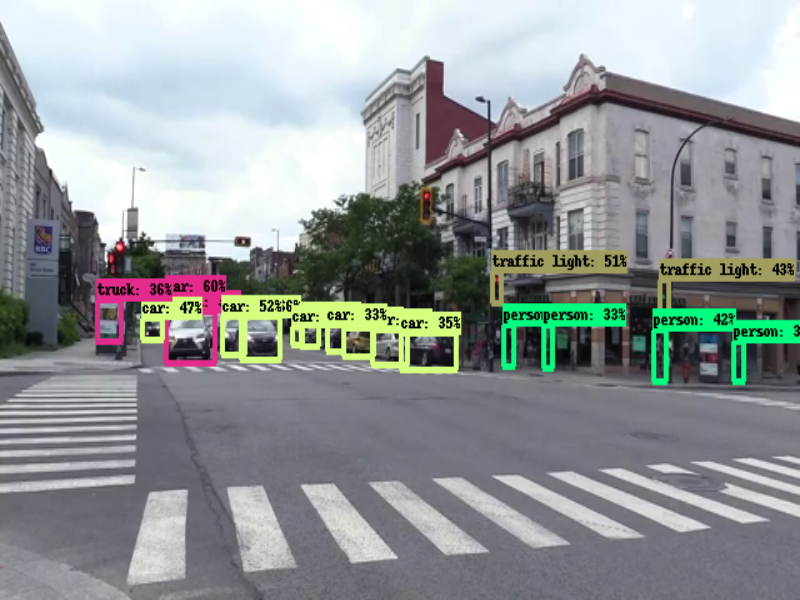

Average FPS: 22.7


In [31]:
num_of_frames = 0

while True:

  num_of_frames += 1

  # Capture frame by frame
  ret, image_np = vs.read()

  # reach the end of stream
  if not ret:
    break

  if height is None or width is None:
    height, width, channels = image_np.shape
    frame_size = (width, height)

  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)

  # Things to try:
  # Flip horizontally
  # image_np = np.fliplr(image_np).copy()

  # Convert image to grayscale
  # image_np = np.tile(
  #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

  start = time.time()
  detections, predictions_dict, shapes = detect_fn(input_tensor)
  end = time.time()

  time_array.append(end-start)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

  # wait unitl the next frame is ready, then clear cell output
  clear_output(wait=True)

  # store this frame with detections
  frame_array.append(image_np_with_detections)

  # Display output
  cv2_imshow(cv2.resize(image_np_with_detections, (800, 600)))


average_fps = num_of_frames / np.sum(time_array)

print('Average FPS: {:.1f}'.format(average_fps))

vs.release()

Export the frames with detections to a video

In [32]:
vs_writer = cv2.VideoWriter('street_detected.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 30, frame_size)

for i in range(len(frame_array)):
  vs_writer.write(frame_array[i])
  
vs_writer.release()